In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from utility.get_twitter import *
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from utility.text_normalizer import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data = pd.read_csv('../data/tagged_tweets.csv')
data.head()

,tweet_id,tweet,revelant,sighting,lost_pet,coyote_death,eating,pet_coyote_interaction,traffic,howling
0,1.455952e+14,@OnlineAlison Several comments later… “I feed ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.455952e+14,@johnlevenstein If we hadn’t defunded police t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.455933e+14,@TheOGpianoGeek That her COYOTE dues are late...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.455932e+14,Hey Coyotes! There is a virtual PFC meeting ne...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.455930e+14,@DunkaPeacecraft The Dems have been in power f...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
X = data['tweet']
y = data['revelant']

# Split data into train, validation, test

In [4]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=.25)
X_train.shape, X_val_test.shape, y_train.shape, y_val_test.shape

((316,), (106,), (316,), (106,))

### Split val_test into validation and test

In [5]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=.5)
X_val.shape, y_val.shape, X_test.shape, y_test.shape

((53,), (53,), (53,), (53,))

# Model 1: CountVectorizer() -> NBmodel

In [6]:
count_vec = CountVectorizer()
nb = MultinomialNB()
pipeline = Pipeline(steps=[('wordcount', count_vec), ('bayes', nb)])

In [7]:
params = {
    'wordcount__preprocessor': [tweet_preprocessor],
    'wordcount__ngram_range': [(1,2), (1,1), (2,2)],
    'wordcount__stop_words': ['english'],
    'wordcount__lowercase': [True],
    'wordcount__strip_accents': ['ascii'],
    'wordcount__min_df': [0, 1, 2],
    'bayes__alpha': [0, 1, 2],
}

In [8]:
wc_nb = GridSearchCV(pipeline, param_grid=params, n_jobs=-1)

In [9]:
%%time
wc_nb.fit(X_train, y_train)

CPU times: user 3.6 s, sys: 183 ms, total: 3.78 s
Wall time: 1min 42s


GridSearchCV(estimator=Pipeline(steps=[('wordcount', CountVectorizer()),
                                       ('bayes', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'bayes__alpha': [0, 1, 2],
                         'wordcount__lowercase': [True],
                         'wordcount__min_df': [0, 1, 2],
                         'wordcount__ngram_range': [(1, 2), (1, 1), (2, 2)],
                         'wordcount__preprocessor': [<function tweet_preprocessor at 0x7f9a0869db80>],
                         'wordcount__stop_words': ['english'],
                         'wordcount__strip_accents': ['ascii']})

In [10]:
wc_nb.best_estimator_

Pipeline(steps=[('wordcount',
                 CountVectorizer(min_df=2, ngram_range=(1, 2),
                                 preprocessor=<function tweet_preprocessor at 0x7f9a0869db80>,
                                 stop_words='english', strip_accents='ascii')),
                ('bayes', MultinomialNB(alpha=1))])

## Metrics

In [11]:
def print_scores(model, y_true, X_val):
    y_hat = model.predict_proba(X_val)[:,1]
    y_pred = model.predict(X_val)
    print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))
    print(f'Log Loss: {log_loss(y_true, y_hat):.2f}')
    sns.heatmap(confusion_matrix(y_true, y_pred).T, square=True, annot=True, fmt='d')

              precision    recall  f1-score   support

  irrelevant       0.91      1.00      0.95        40
    relevant       1.00      0.69      0.82        13

    accuracy                           0.92        53
   macro avg       0.95      0.85      0.89        53
weighted avg       0.93      0.92      0.92        53

Log Loss: 0.29


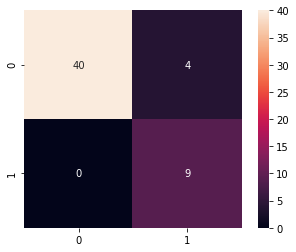

In [12]:
print_scores(wc_nb,y_val, X_val)

# Model 2: tfifd -> NBmodel

In [13]:
tfidf = TfidfVectorizer(preprocessor=tweet_preprocessor, smooth_idf=True, stop_words='english', lowercase=True)
nbc = MultinomialNB()
model2_pipeline = Pipeline([('tfidf', tfidf), ('nbc', nbc)])
model2_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'nbc', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'nbc__alpha', 'nbc__class_prior', 'nbc__fit_prior'])

In [14]:
model2_params = {
    'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__max_df': [1,2],
    'tfidf__min_df': [1,2],
    'nbc__alpha': [0.01, 0.1,1]
}

In [15]:
tfidf_nbc = GridSearchCV(model2_pipeline, param_grid=model2_params, n_jobs=-1, verbose=3, cv=3)

In [16]:
tfidf_nbc.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.72779275 0.70569033 0.74687032        nan        nan        nan
 0.75630428 0.75627433 0.74687032 0.8196466  0.81012279 0.75944894
 0.73411201 0.73411201 0.74372567        nan        nan        nan
 0.77526205 0.775292   0.74687032 0.81018269 0.81329739 0.76262354
 0.75315963 0.74998503 0.74998503        nan        nan        nan
 0.75315963 0.74998503 0.74998503 0.78796047 0.78478586 0.75633423]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function tweet_preprocessor at 0x7f9a0869db80>,
                                                        stop_words='english')),
                                       ('nbc', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nbc__alpha': [0.01, 0.1, 1], 'tfidf__max_df': [1, 2],
                         'tfidf__min_df': [1, 2],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=3)

In [17]:
tfidf_nbc.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=2, min_df=2,
                                 preprocessor=<function tweet_preprocessor at 0x7f9a0869db80>,
                                 stop_words='english')),
                ('nbc', MultinomialNB(alpha=0.01))])

              precision    recall  f1-score   support

  irrelevant       0.82      0.90      0.86        40
    relevant       0.56      0.38      0.45        13

    accuracy                           0.77        53
   macro avg       0.69      0.64      0.66        53
weighted avg       0.75      0.77      0.76        53

Log Loss: 0.70


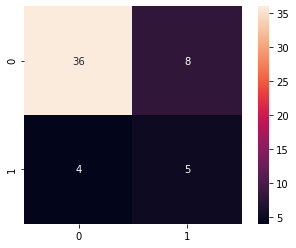

In [18]:
print_scores(tfidf_nbc, y_val, X_val)

# Model 3: CountVectorizer -> ComplementNB

In [19]:
count_vec = CountVectorizer(preprocessor=tweet_preprocessor, input='content', decode_error='ignore', stop_words='english', lowercase=True, strip_accents='ascii')
cnb = ComplementNB()
model3_pipeline = Pipeline(steps=[('wordcount', count_vec), ('bayes', cnb)])

In [20]:
params = {
    'wordcount__ngram_range': [(1,2), (1,1), (2,2)],
    'wordcount__min_df': [0, 1, 2, 3],
    'bayes__alpha': [0.1, 0.01, 1, 2],
    'memory': ['wordcount']
}

In [21]:
model3_search = GridSearchCV(model3_pipeline, param_grid=params, n_jobs=-1, verbose=3)

In [22]:
model3_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=Pipeline(steps=[('wordcount',
                                        CountVectorizer(decode_error='ignore',
                                                        preprocessor=<function tweet_preprocessor at 0x7f9a0869db80>,
                                                        stop_words='english',
                                                        strip_accents='ascii')),
                                       ('bayes', ComplementNB())]),
             n_jobs=-1,
             param_grid={'bayes__alpha': [0.1, 0.01, 1, 2],
                         'memory': ['wordcount'],
                         'wordcount__min_df': [0, 1, 2, 3],
                         'wordcount__ngram_range': [(1, 2), (1, 1), (2, 2)]},
             verbose=3)

In [23]:
model3_search.best_estimator_

Pipeline(memory='wordcount',
         steps=[('wordcount',
                 CountVectorizer(decode_error='ignore', min_df=2,
                                 ngram_range=(2, 2),
                                 preprocessor=<function tweet_preprocessor at 0x7f9a0869db80>,
                                 stop_words='english', strip_accents='ascii')),
                ('bayes', ComplementNB(alpha=0.1))])

              precision    recall  f1-score   support

  irrelevant       0.76      0.97      0.86        40
    relevant       0.50      0.08      0.13        13

    accuracy                           0.75        53
   macro avg       0.63      0.53      0.50        53
weighted avg       0.70      0.75      0.68        53

Log Loss: 0.63


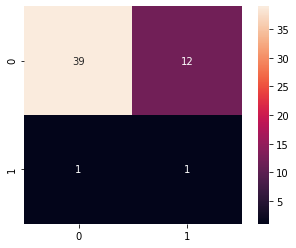

In [24]:
print_scores(model3_search, y_val, X_val)

# Model 4: CountVectorizer -> SVG

In [139]:
count_vec = CountVectorizer(preprocessor=tweet_preprocessor, input='content', decode_error='ignore', stop_words='english', lowercase=True, strip_accents='ascii')
svm = SVC()
model4_pipeline = Pipeline([('count', count_vec), ('svm', svm)])
model4_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'count', 'svm', 'count__analyzer', 'count__binary', 'count__decode_error', 'count__dtype', 'count__encoding', 'count__input', 'count__lowercase', 'count__max_df', 'count__max_features', 'count__min_df', 'count__ngram_range', 'count__preprocessor', 'count__stop_words', 'count__strip_accents', 'count__token_pattern', 'count__tokenizer', 'count__vocabulary', 'svm__C', 'svm__break_ties', 'svm__cache_size', 'svm__class_weight', 'svm__coef0', 'svm__decision_function_shape', 'svm__degree', 'svm__gamma', 'svm__kernel', 'svm__max_iter', 'svm__probability', 'svm__random_state', 'svm__shrinking', 'svm__tol', 'svm__verbose'])

In [146]:
params = {
    'count__ngram_range': [(1,2), (1,1)],
    'count__min_df': [0, 1],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__C': [0.01, 0.5, 1, 5, 10],
    'svm__class_weight': [None, 'balanced'],
}

In [147]:
model4_search = GridSearchCV(model4_pipeline, param_grid=params, n_jobs=-1, verbose=5)

In [148]:
model4_search.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(estimator=Pipeline(steps=[('count',
                                        CountVectorizer(decode_error='ignore',
                                                        preprocessor=<function tweet_preprocessor at 0x7f7b3a6fd9d0>,
                                                        stop_words='english',
                                                        strip_accents='ascii')),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'count__min_df': [0, 1],
                         'count__ngram_range': [(1, 2), (1, 1)],
                         'svm__C': [0.01, 0.5, 1, 5, 10],
                         'svm__class_weight': [None, 'balanced'],
                         'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=5)

In [158]:
model4_search.best_params_

{'count__min_df': 0,
 'count__ngram_range': (1, 1),
 'svm__C': 5,
 'svm__class_weight': 'balanced',
 'svm__kernel': 'sigmoid'}

              precision    recall  f1-score   support

  irrelevant       0.81      0.92      0.86        37
    relevant       0.73      0.50      0.59        16

    accuracy                           0.79        53
   macro avg       0.77      0.71      0.73        53
weighted avg       0.78      0.79      0.78        53



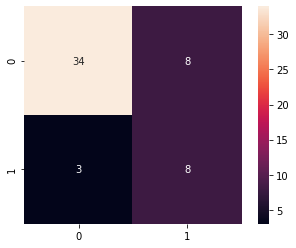

In [154]:
print_scores(model4_search, y_val, X_val)

In [25]:
count_vec = CountVectorizer(preprocessor=tweet_preprocessor, input='content', decode_error='ignore', stop_words='english', lowercase=True, strip_accents='ascii', min_df=0, ngram_range=(1,1))
svm = SVC(probability=True, class_weight='balanced', kernel='sigmoid', C=5)
svm_pipeline = Pipeline([('count', count_vec), ('svm', svm)])

In [26]:
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('count',
                 CountVectorizer(decode_error='ignore', min_df=0,
                                 preprocessor=<function tweet_preprocessor at 0x7f9a0869db80>,
                                 stop_words='english', strip_accents='ascii')),
                ('svm',
                 SVC(C=5, class_weight='balanced', kernel='sigmoid',
                     probability=True))])

              precision    recall  f1-score   support

  irrelevant       0.89      0.97      0.93        40
    relevant       0.89      0.62      0.73        13

    accuracy                           0.89        53
   macro avg       0.89      0.80      0.83        53
weighted avg       0.89      0.89      0.88        53

Log Loss: 0.34


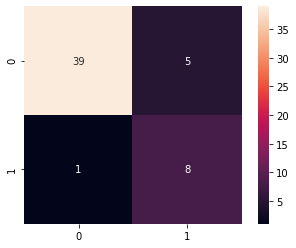

In [27]:
print_scores(svm_pipeline, y_val, X_val)

# Final model: MultinomialNB

              precision    recall  f1-score   support

  irrelevant       0.93      0.95      0.94        39
    relevant       0.85      0.79      0.81        14

    accuracy                           0.91        53
   macro avg       0.89      0.87      0.88        53
weighted avg       0.90      0.91      0.90        53

Log Loss: 0.28


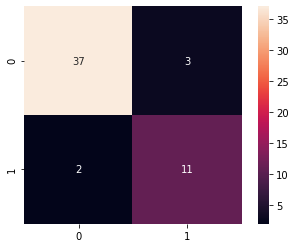

In [28]:
# Score for final model using test set
print_scores(wc_nb, y_test, X_test)

              precision    recall  f1-score   support

  irrelevant       0.91      1.00      0.95        40
    relevant       1.00      0.69      0.82        13

    accuracy                           0.92        53
   macro avg       0.95      0.85      0.89        53
weighted avg       0.93      0.92      0.92        53

Log Loss: 0.29


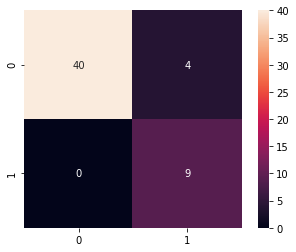

In [29]:
# Compare with validation set
print_scores(wc_nb, y_val, X_val)

# Save model

In [30]:
import joblib

In [31]:
with open('../bayes_model/best_bayes_pipeline.pkl', 'wb') as f:
    joblib.dump(wc_nb, f)